In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import shutil
import argparse
import time
import json
from datetime import datetime
from collections import defaultdict
from itertools import islice
import pickle
import copy
import numpy as np
import cv2
from easydict import EasyDict
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel
from tensorboardX import SummaryWriter

from mvn.models.triangulation import  VolumetricTriangulationNet
from mvn.models.volumetric_adain import VolumetricTemporalAdaINNet
from mvn.models.v2v import AdaIN, V2VModel, Basic3DBlock, Res3DBlock, Upsample3DBlock, Pool3DBlock, EncoderDecorder
from mvn.models import v2v
from mvn.models.temporal import get_normalization, Res1DBlock
from mvn.models.loss import KeypointsMSELoss, KeypointsMSESmoothLoss, KeypointsMAELoss, KeypointsL2Loss, VolumetricCELoss
from mvn.models import pose_hrnet, pose_resnet
from mvn.utils import img, multiview, op, vis, misc, cfg
from mvn.datasets.human36m import Human36MTemporalDataset, Human36MMultiViewDataset
from mvn.datasets import utils as dataset_utils

from mvn.utils.multiview import project_3d_points_to_image_plane_without_distortion
from mvn.utils.vis import draw_2d_pose
from mvn.utils import img
from mvn.utils import volumetric
from mvn.utils import op
from mvn.utils import vis
from mvn.utils import misc
from mvn.utils import cfg
from mvn.datasets import utils as dataset_utils
from mvn.utils.img import image_batch_to_numpy, denormalize_image,to_numpy

from tqdm import tqdm_notebook

from torch.nn.utils.rnn import pack_padded_sequence
from pytorch_convolutional_rnn.convolutional_rnn import Conv3dLSTM, Conv3dPeepholeLSTM, Conv2dLSTMCell, Conv2dPeepholeLSTM

CONNECTIVITY_DICT = {
    'cmu': [(0, 2), (0, 9), (1, 0), (1, 17), (2, 12), (3, 0), (4, 3), (5, 4), (6, 2), (7, 6), (8, 7), (9, 10), (10, 11), (12, 13), (13, 14), (15, 1), (16, 15), (17, 18)],
    'coco': [(0, 1), (0, 2), (1, 3), (2, 4), (5, 7), (7, 9), (6, 8), (8, 10), (11, 13), (13, 15), (12, 14), (14, 16), (5, 6), (5, 11), (6, 12), (11, 12)],
    "mpii": [(0, 1), (1, 2), (2, 6), (5, 4), (4, 3), (3, 6), (6, 7), (7, 8), (8, 9), (8, 12), (8, 13), (10, 11), (11, 12), (13, 14), (14, 15)],
    "human36m": [(0, 1), (1, 2), (2, 6), (5, 4), (4, 3), (3, 6), (6, 7), (7, 8), (8, 16), (9, 16), (8, 12), (11, 12), (10, 11), (8, 13), (13, 14), (14, 15)],
    "kth": [(0, 1), (1, 2), (5, 4), (4, 3), (6, 7), (7, 8), (11, 10), (10, 9), (2, 3), (3, 9), (2, 8), (9, 12), (8, 12), (12, 13)],
}

from train import setup_human36m_dataloaders

device = 'cuda:0'

def get_capacity(model):
    s_total = 0
    for param in model.parameters():
        s_total+=param.numel()
    return round(s_total / (10**6),2)

In [2]:
!nvidia-smi

Wed Jun 17 15:33:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   53C    P8    17W / 280W |   1385MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 88%   82C    P2   197W / 280W |  10751MiB / 11178MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
        

# Eidetic LSTM 3D

In [3]:
from mvn.models.e3d_lstm import E3DLSTM, E3DLSTMCell

In [7]:
C=64
H=32
W=32
D=32
time = 6
batch_size=2
X = torch.randn(time,batch_size,C,H,W,D).cuda()
e3d = E3DLSTM(input_shape=list(X.shape[-4:]), hidden_size=64, num_layers = 1, kernel_size=(2, 2, 2), tau=2).cuda()
e3d(X).shape

torch.Size([2, 6, 64, 32, 32, 32])

In [8]:
!nvidia-smi

Wed Jun 17 17:02:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 54%   63C    P2   185W / 280W |   4594MiB / 11177MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 96%   87C    P2   313W / 280W |   3575MiB / 11178MiB |     92%      Default |
+-------------------------------+----------------------+----------------------+
        

# All model sanity check

In [2]:
config_path = './experiments/human36m/train/human36m_vol_temporal_adain.yaml'

config = cfg.load_config(config_path)
config.dataset.val.retain_every_n_frames_in_test = 1

_, val_loader, _ = setup_human36m_dataloaders(config,
                                             is_train=False,
                                             distributed_train=False)

batch_size, dt, dilation = val_loader.batch_size, val_loader.dataset.dt, val_loader.dataset.dilation

pivot_type = config.dataset.pivot_type 
keypoints_per_frame = config.dataset.val.keypoints_per_frame if hasattr(config.dataset.val, 'keypoints_per_frame') else False
pivot_position = {'first':-1, 'intermediate':dt//2}[pivot_type]

if not hasattr(config.model.backbone, 'group_norm'):
    config.model.backbone.group_norm = False

print('Batch size:', batch_size, '\n',\
      'dt:', dt, '\n',\
      'dilation:', dilation, '\n',\
      'pivot_type:', pivot_type, '\n',\
      'pivot_position:', pivot_position,'\n',\
      'keypoints_per_frame', keypoints_per_frame)
    


Batch size: 1 
 dt: 10 
 dilation: 1 
 pivot_type: first 
 pivot_position: -1 
 keypoints_per_frame False


In [6]:
model = {
    "vol": VolumetricTriangulationNet,
    "vol_temporal_adain":VolumetricTemporalAdaINNet
}[config.model.name](config, device=device).to(device)

print ('Loaded {} model'.format(config.model.name))

Loading pretrained weights from: ./data/pose_resnet_4.5_pixels_human36m.pth
Successfully loaded pretrained weights for backbone
Only resnet50 backbone is used...
backbone:  34.0M
motion_extractor:  75.97M
volume_net:  57.39M
process_features:  0.02M
Loaded vol_temporal_adain model


In [8]:
x = torch.randn(1,3,9,112,112).cuda()
model.motion_extractor(x).shape

torch.Size([1, 64, 96, 96])

In [ ]:
# model = {
#     "vol": VolumetricTriangulationNet,
#     "vol_temporal_adain":VolumetricTemporalAdaINNet
# }[config.model.name](config, device=device).to(device)

# print ('Loaded {} model'.format(config.model.name))

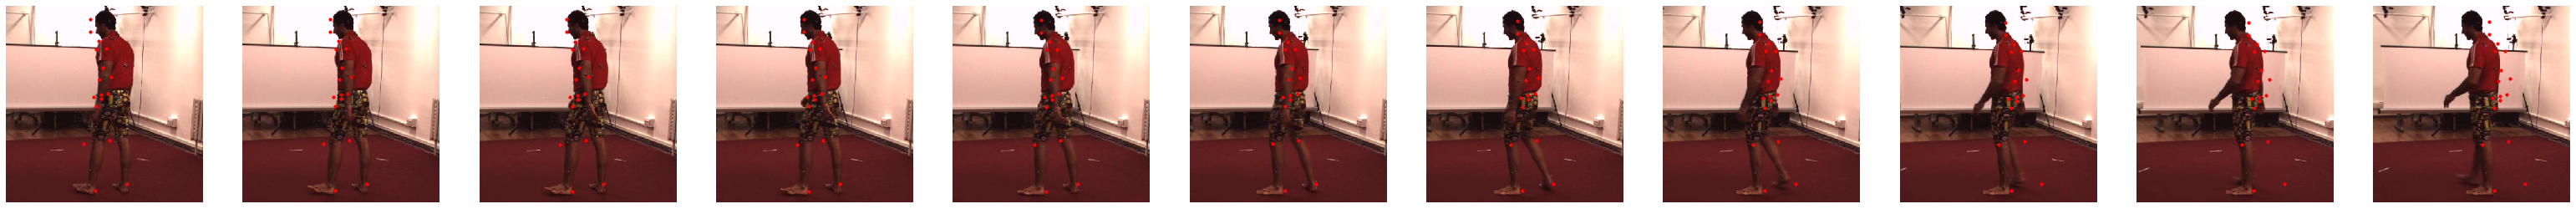

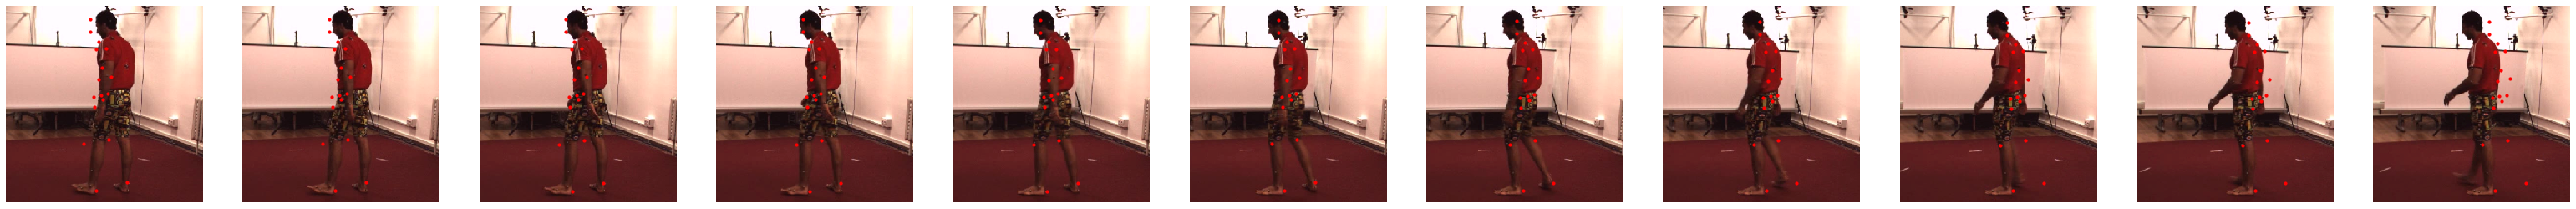

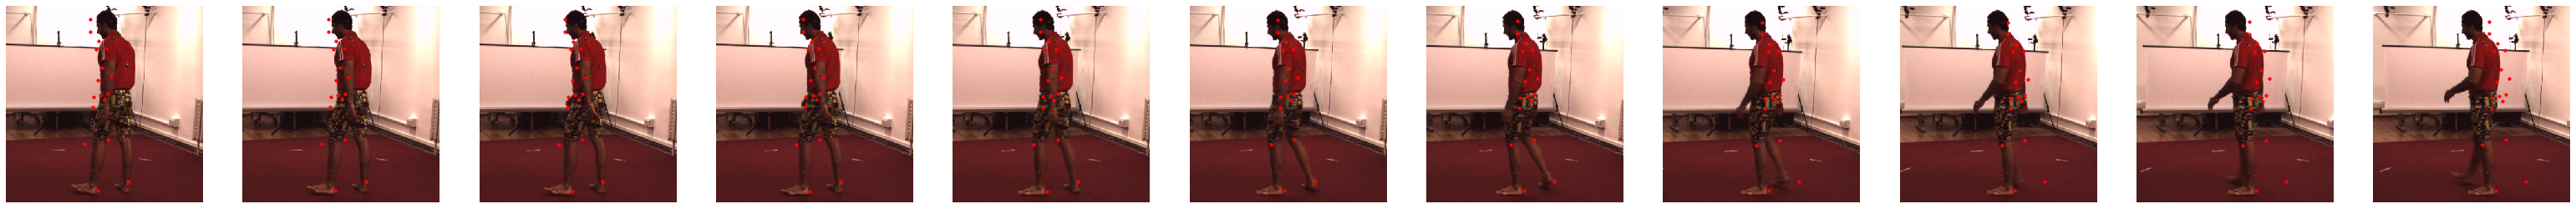

In [35]:
for batch in islice(val_loader, 50, 53, 1):

    n_views = batch['images'].shape[1]
    batch_size = batch['images'].shape[0]
    
    fig, axes = plt.subplots(ncols=n_views, nrows=1, figsize=(5 * n_views, 5))
    for i in range(n_views):
        # first row
        detection = batch['detections'][0][i]
        *bbox, c = detection
        
        image = batch['images'][0][i]
        image = denormalize_image(image).astype(np.uint8)
        image = image[..., ::-1]  # bgr -> rgb
        camera_name = batch['cameras'][i][0].name
        title = "{}, detection conf: {:.3}".format(camera_name, c)
        
        # second row
        keypoints_3d = batch['keypoints_3d'][0][:, :3]
        proj_matrix = batch['cameras'][i][0].projection
#         image_shape_before_resize = batch['image_shapes_before_resize'][0][i]
        image_shape = image.shape[:2]

        keypoints_2d_wrt_new = multiview.project_3d_points_to_image_plane_without_distortion(proj_matrix, keypoints_3d)
#         keypoints_2d_wrt_orig = transform_points_after_crop_and_resize(keypoints_2d_wrt_new, (bbox[0], bbox[1]), image_shape_before_resize, image_shape, forward=True)
        
        axes[i].set_xlim(0, image.shape[1])
        axes[i].set_ylim(0, image.shape[0])
        axes[i].invert_yaxis()
        axes[i].imshow(image)
        axes[i].scatter(keypoints_2d_wrt_new[:, 0], keypoints_2d_wrt_new[:, 1], s=10, c='red')
        
        axes[i].axis('off')
    plt.show()

In [19]:
# f = torch.randn(1,256,5,96,96).cuda()
# s = model.features_sequence_to_vector(f)
# s.shape

torch.Size([1, 64, 5, 24, 24])

In [51]:
keypoints = val_loader.dataset.labels['table'][200]['keypoints']
keypoints = keypoints[:,[1,2]]
connectivity = CONNECTIVITY_DICT['human36m']

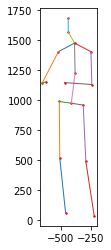

In [52]:
ax = plt.subplot(1,1,1)
# points
point_size=2
ax.scatter(keypoints[:, 0], keypoints[:, 1], c='red', s=point_size)
line_width=1
radius=None
color=None

keypoints_mask = [True] * len(keypoints)
# connections
for (index_from, index_to) in connectivity:
    if keypoints_mask[index_from] and keypoints_mask[index_to]:
        xs, ys = [np.array([keypoints[index_from, j], keypoints[index_to, j]]) for j in range(2)]
        ax.plot(xs, ys, c=color, lw=line_width)

if radius is not None:
    root_keypoint_index = 0
    xroot, yroot = keypoints[root_keypoint_index, 0], keypoints[root_keypoint_index, 1]

    ax.set_xlim([-radius + xroot, radius + xroot])
    ax.set_ylim([-radius + yroot, radius + yroot])

ax.set_aspect('equal')


# Pretrained R(2+1)D

In [ ]:
# for batch in val_loader:
#     break

In [ ]:
# (images_batch, 
# keypoints_3d_gt, 
# keypoints_3d_validity_gt, 
# proj_matricies_batch) = dataset_utils.prepare_batch(batch, device)

In [33]:
from torchvision.models.video.resnet import VideoResNet, BasicBlock, R2Plus1dStem, Conv2Plus1D 
from collections import OrderedDict
weights_path = './data/r2plus1d_34_clip8_ig65m_from_scratch-9bae36ae.pth'

def change_stride(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.Conv3d) and (np.array(child.stride) > 1).any():
            child.stride = (1,1,1)
        else:
            change_stride(child)      

motion_extractor = VideoResNet(block=BasicBlock,
                                conv_makers=[Conv2Plus1D] * 4,
                                layers=[3, 4, 6, 3], # [3,4,6,3]
                                stem=R2Plus1dStem)
motion_extractor.layer2[0].conv2[0] = Conv2Plus1D(128, 128, 288)
motion_extractor.layer3[0].conv2[0] = Conv2Plus1D(256, 256, 576)
motion_extractor.layer4[0].conv2[0] = Conv2Plus1D(512, 512, 1152)

new_model = nn.Sequential(OrderedDict([('stem',motion_extractor.stem), 
                                       ('layer1',motion_extractor.layer1), 
                                          ('layer2',motion_extractor.layer2),
                                          ('layer3',motion_extractor.layer3)]))


weights_dict = torch.load(weights_path, map_location=device)
model_dict = new_model.state_dict()
new_pretrained_state_dict = {}

for k, v in weights_dict.items():
    if k in model_dict:
        new_pretrained_state_dict[k] = weights_dict[k]
new_model.load_state_dict(new_pretrained_state_dict)

# We need exact Caffe2 momentum for BatchNorm scaling
normalization_type = 'batch_norm'
if normalization_type == 'batch_norm':
    for m in new_model.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eps = 1e-3
            m.momentum = 0.9
elif normalization_type == 'group_norm':
    for m in new_model.modules():
        if isinstance(m, nn.BatchNorm3d):
            m = nn.GroupNorm(32, m.num_features)

size = 112      
change_stride(new_model.layer3)
new_model = new_model.cuda()
x = torch.randn(3,3,5,size,size).cuda()
print ('shape:',new_model(x).shape , 'capacity:', get_capacity(new_model))

shape: torch.Size([3, 256, 3, 28, 28]) capacity: 24.41


In [19]:
x = torch.tensor([[1,1,1],
                 [1,0,1],
                 [1,1,1]]).unsqueeze(0).unsqueeze(0).float()

x = torch.randn(1,1,3,3)
ap = nn.AdaptiveAvgPool2d((96,96))
ap_x = ap(x)

In [37]:
x = torch.randn(5,256,5,32,32)
nn.AdaptiveAvgPool3d((1,32,32))(x).shape

torch.Size([5, 256, 1, 32, 32])

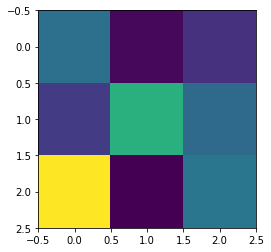

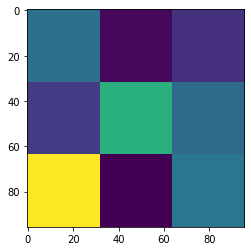

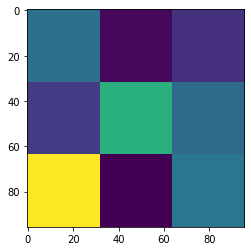

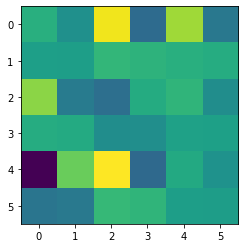

In [27]:
plt.figure()
plt.imshow(x[0,0].numpy())
plt.figure()
plt.imshow(ap_x[0,0].numpy())
plt.figure()
aps_x = F.upsample(x, size=(96,96))
plt.imshow(aps_x[0,0].numpy())
plt.figure()
c_x = nn.ConvTranspose2d(1,1,kernel_size=2, stride=2)(x).detach()
plt.imshow(c_x[0,0].numpy())



In [3]:
# from torchvision.models.video.resnet import VideoResNet, BasicBlock, R2Plus1dStem, Conv2Plus1D, Conv3DNoTemporal, Conv3DSimple

# Upscale block

In [25]:
from mvn.models.v2v import get_normalization
class Conv1Plus2D(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, time_padding, normalization_type='batch_norm'):
        super().__init__()
        self.block = nn.Sequential(        
            nn.ConvTranspose3d(in_planes, 
                    out_planes, 
                    kernel_size=kernel_size, 
                    stride=(1, 1, 1), 
                    bias=False),
            get_normalization(normalization_type, out_planes),
            nn.ReLU(True),
            nn.Conv3d(out_planes, 
                    out_planes, 
                    kernel_size=(3, 1, 1), 
                    stride=(1, 1, 1), 
                    padding=(time_padding,0,0),
                    bias=False),
            get_normalization(normalization_type, out_planes),
            nn.ReLU(True)
            )

    def forward(self, x):
        return self.block(x)    

n_upscale_layers = 3
upscale_heatmap_shape = [96,96]
output_features = 256

out_shape = np.array([1, *upscale_heatmap_shape])
r2d_shape = np.array([1, 14,14])
diff_shape = (out_shape - r2d_shape) 
kernel_size = 1 + (diff_shape//n_upscale_layers)
kernel_size_residual = 1 + diff_shape%n_upscale_layers
assert (diff_shape >= 0).all()
hidden_dim = output_features // 2

layers = []
for i in range(n_upscale_layers):
    in_planes = output_features if i == 0 else hidden_dim
    out_planes = hidden_dim
    padding = 1 if i < (n_upscale_layers-1) else 0
    layers.append(Conv1Plus2D(in_planes, 
                              out_planes, 
                              kernel_size,
                              time_padding=padding))

# last block    
layers.append(nn.ConvTranspose3d(hidden_dim,
                                 44,
                                 kernel_size=kernel_size_residual))
layers.append(nn.ReLU()) 
final_layer = nn.Sequential(*layers)               

In [26]:
x = torch.randn(1,256,3,14,14)
final_layer(x).shape

torch.Size([1, 44, 1, 96, 96])

# Pretrained V2V: C3D


In [2]:
features_sequence_to_vector = C3D(5,3)    

weights_dict = torch.load('./data/c3d.pickle', map_location=device)
model_dict = features_sequence_to_vector.state_dict()
new_pretrained_state_dict = {}

for k, v in weights_dict.items():
    if k in model_dict:
        new_pretrained_state_dict[k] = weights_dict[k]
    else:    
        print (k, 'hasnt been loaded in C3D')

features_sequence_to_vector.load_state_dict(new_pretrained_state_dict)
features_sequence_to_vector.to(device)
print (get_capacity(features_sequence_to_vector))

conv4a.weight hasnt been loaded in C3D
conv4a.bias hasnt been loaded in C3D
conv4b.weight hasnt been loaded in C3D
conv4b.bias hasnt been loaded in C3D
conv5a.weight hasnt been loaded in C3D
conv5a.bias hasnt been loaded in C3D
conv5b.weight hasnt been loaded in C3D
conv5b.bias hasnt been loaded in C3D
fc6.weight hasnt been loaded in C3D
fc6.bias hasnt been loaded in C3D
fc7.weight hasnt been loaded in C3D
fc7.bias hasnt been loaded in C3D
fc8.weight hasnt been loaded in C3D
fc8.bias hasnt been loaded in C3D
2.88


# TemporalDiscr


In [75]:
class TemporalDiscriminator(nn.Module):
    """docstring for TemporalDiscriminator"""
    def __init__(self, 
                 input_features_dim, 
                 output_features_dim=1024, 
                 intermediate_channels=512, 
                 normalization_type='group_norm',
                 dt = 8,
                 kernel_size = 3,
                 n_groups = 32):
        
        super().__init__()
        self.input_features_dim = input_features_dim
        self.output_features_dim = output_features_dim
        self.intermediate_channels = intermediate_channels
        self.normalization_type = normalization_type
        
        self.first_block = Res1DBlock(input_features_dim, 
                                      intermediate_channels,
                                      kernel_size=1,
                                      normalization_type=normalization_type)
        
        l = dt
        blocks =  []
        while l >= kernel_size:
            l = l - kernel_size + 1
            blocks.append(Res1DBlock(intermediate_channels, 
                                     intermediate_channels, 
                                     kernel_size=kernel_size,
                                     normalization_type=normalization_type))

            blocks.append(nn.Sequential(nn.Conv1d(intermediate_channels, intermediate_channels, kernel_size=3, padding=1),
                                        get_normalization(normalization_type, intermediate_channels, n_groups=n_groups, dimension=1),
                                        nn.ReLU(True),
                                        nn.Conv1d(intermediate_channels, intermediate_channels, kernel_size=3, padding=1),
                                        get_normalization(normalization_type, intermediate_channels, n_groups=n_groups, dimension=1),
                                        nn.ReLU(True)
                                        ))
        
        self.blocks = nn.Sequential(*blocks)    
        self.final_block = nn.Conv1d(intermediate_channels, 
                                      output_features_dim,
                                      kernel_size=l)
        
    def forward(self, x, device='cuda:0'):
        # [batch_size, dt, feature_shape]
        x = x.transpose(1,2) # [batch_size, dt, feature_shape] -> [batch_size, feature_shape, dt]
        x  = self.first_block(x)
        x  = self.blocks(x)
        x  = self.final_block(x)
        
        return x[...,0]

In [88]:
x = torch.randn(4,8,17,3)
[1,2,3,4][-2:]

[3, 4]